### In this notebook, we try to run two-stage pipeline. Namely, we first detect jersey number region , and then pass this crop to image classifier (trained on SVHN). And check its accuracy.

#### First, let's get some small crops of jersey numbers

In [1]:
import mmcv
import matplotlib.pyplot as plt
import cv2
import glob
import os
import json
import time
import random
from tqdm.notebook import tqdm
import numpy as np
import torchvision
from mmdet.apis import init_detector, inference_detector, inference_batch_detector

import argparse
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.jit
import torch.nn as nn

In [2]:
imgs_dir = '../../data/player_tracking_frames/'
# orig_anno_dir = sorted(glob.glob('../../PlayerTracking/data/raw_data/2018-11-28_Virginia_at_Maryland/*'))
jersey_anno_dir = glob.glob('../../PlayerTracking/data/second_task/*')

In [3]:
def crop_from_orig_anno(jersey_anno_dir, imgs_dir, offset = 3):
    all_anno = []
    
    
    
    for anno_dir in tqdm(jersey_anno_dir): 

        js_dir  = sorted(glob.glob(anno_dir + '/*.json'))


        for jersey_js in js_dir:

            ### Load new jersey data
            with open(jersey_js) as f:
                jersey_data = json.load(f)

            ### Load image data
            img_path = os.path.join(imgs_dir, os.path.basename(anno_dir), "frame_" + os.path.basename(jersey_js).replace('.json', '.jpg'))
            img = cv2.imread(img_path)

            for shape in jersey_data['shapes']:

                label = shape['label']
                if 'j' in label:
                    label_split = label.split('_')
                    if len(label_split)==3:
                        track_id = label_split[1]
                        jersey_num = label_split[2]
                    elif len(label_split)==4:
                        track_id = label_split[1] + '_' + label_split[2]
                        jersey_num = label_split[-1]
                    
                    bbox_ = np.array([[int(x) for x in y] for y in shape['points']])
                    bbox_ = bbox_.flatten()

                    bbox_img = img[bbox_[1] - offset: bbox_[3] + offset, 
                                   bbox_[0] - offset: bbox_[2] + offset, :]
                    h,w,c = bbox_img.shape
                    if h!=0 and w!=0:
                        all_anno.append((bbox_img, jersey_num))
                        
    return all_anno

In [21]:
all_anno = crop_from_orig_anno(jersey_anno_dir, imgs_dir)
print("Number of samples is ", len(all_anno))


Number of samples is  13607


In [165]:
hs,ws = [], []
for img, _ in all_anno:
    h,w,_  = img.shape
    hs.append(h)
    ws.append(w)
    
print(sum(hs)/len(hs), sum(ws)/len(ws))

27.481884324244874 23.90218270008084


34


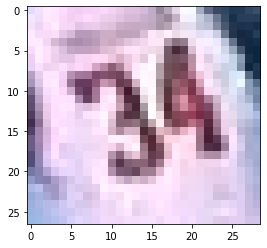

In [36]:
idx = 0
idx = random.choice(list(range(len(all_anno))))
print(all_anno[idx][1])
plt.imshow(all_anno[idx][0])

### Now let's run the best image classifier in the world!

In [ ]:
crct = 0
results = []
for crop, label in tqdm(all_anno):
    res = _infer_jersey(class_model, crop)
    res = int(''.join([str(x) for x in res if x!=10]))
    
    results.append((res, label))
    if res == int(label):
        crct += 1
        

print('Accuracy is ', (crct / len(all_anno))*100)        

In [2]:
class JerseyModel(torch.nn.Module):
    CHECKPOINT_FILENAME_PATTERN = 'model-{}.pth'

    # __constants__ = ['_hidden1', '_hidden2', '_hidden3', '_hidden4', '_hidden5',
    #                  '_hidden6', '_hidden7', '_hidden8', '_hidden9', '_hidden10',
    #                  '_features', '_classifier',
    #                  '_digit_length', '_digit1', '_digit2', '_digit3', '_digit4', '_digit5']

    def __init__(self, inter_size=7):
        super(JerseyModel, self).__init__()

        self.inter_size = inter_size
        self._hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        self._hidden9 = nn.Sequential(
            nn.Linear(192 * self.inter_size * self.inter_size, 3072),
            nn.ReLU()
        )
        self._hidden10 = nn.Sequential(
            nn.Linear(3072, 3072),
            nn.ReLU()
        )

        self._digit_length = nn.Sequential(nn.Linear(3072, 4))
        self._digit1 = nn.Sequential(nn.Linear(3072, 11))
        self._digit2 = nn.Sequential(nn.Linear(3072, 11))


    # @torch.jit.script_method
    def forward(self, x):
        # print(x.size())
        x = self._hidden1(x)
        x = self._hidden2(x)
        x = self._hidden3(x)
        x = self._hidden4(x)
        x = self._hidden5(x)
        x = self._hidden6(x)
        x = self._hidden7(x)
        x = self._hidden8(x)
        # print(x.size())
        x = x.view(x.size(0), 192 * self.inter_size * self.inter_size)
        x = self._hidden9(x)
        x = self._hidden10(x)

        length_logits = self._digit_length(x)
        digit1_logits = self._digit1(x)
        digit2_logits = self._digit2(x)


        return length_logits, digit1_logits, digit2_logits

    def store(self, path_to_dir, step, maximum=5):
        path_to_models = glob.glob(os.path.join(path_to_dir, Model.CHECKPOINT_FILENAME_PATTERN.format('*')))
        if len(path_to_models) == maximum:
            min_step = min([int(path_to_model.split('/')[-1][6:-4]) for path_to_model in path_to_models])
            path_to_min_step_model = os.path.join(path_to_dir, Model.CHECKPOINT_FILENAME_PATTERN.format(min_step))
            os.remove(path_to_min_step_model)

        path_to_checkpoint_file = os.path.join(path_to_dir, Model.CHECKPOINT_FILENAME_PATTERN.format(step))
        torch.save(self.state_dict(), path_to_checkpoint_file)
        return path_to_checkpoint_file

    def restore(self, path_to_checkpoint_file):
        self.load_state_dict(torch.load(path_to_checkpoint_file))
        step = int(path_to_checkpoint_file.split('/')[-1][6:-4])
        return step
    
def _infer_jersey(model, numpy_image):


    with torch.no_grad():
        transform = transforms.Compose([
            transforms.CenterCrop([54, 54]),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        numpy_image = cv2.resize(numpy_image, (64, 64))

        
        image = Image.fromarray(numpy_image)
        image = transform(image)
        images = image.unsqueeze(dim=0).cuda()

        length_logits, digit1_logits, digit2_logits= model.eval()(images)

        length_prediction = length_logits.max(1)[1]
        digit1_prediction = digit1_logits.max(1)[1]
        digit2_prediction = digit2_logits.max(1)[1]
  

    return [digit1_prediction.item(), digit2_prediction.item()]

In [4]:
# class_model = Model()
class_model = JerseyModel(7)
class_model.restore('../SVHNClassifier-PyTorch/work_dirs/basic_randaug/model-14000.pth')
class_model = class_model.eval().cuda()

In [24]:
print("number of params in basic model is {} M".format(sum(p.numel() for p in class_model.parameters()) / 1000000))

number of params in basic model is 42.758106 M


#### Efficient Net

In [15]:
from efficientnet_pytorch import EfficientNet, get_model_params, round_filters
effNet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

Loaded pretrained weights for efficientnet-b0


In [16]:
blocks_args, global_params = get_model_params('efficientnet-b0', {'image_size':56})

In [17]:
class EfficientJerseyModel(EfficientNet):
    CHECKPOINT_FILENAME_PATTERN = 'model-{}.pth'

    def __init__(self, blocks_args, global_params):
        super(EfficientJerseyModel, self).__init__(blocks_args, global_params)
        
        self.last_channel = round_filters(1280, global_params)
        
        self._fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, 4))
        self._digit1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, 11))
        self._digit2 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, 11))



    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.
        Args:
            inputs (tensor): Input tensor.
        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        
        
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            
            length_logits = self._fc(x)
            digit1_logits = self._digit1(x)
            digit2_logits = self._digit2(x)

        return length_logits, digit1_logits, digit2_logits  
effNet = EfficientJerseyModel(blocks_args, global_params)

In [18]:
print("number of params in effNet is {} M".format(sum(p.numel() for p in effNet.parameters()) / 1000000))

number of params in effNet is 4.040854 M


In [19]:
resnet101 = torchvision.models.resnet101()
print("number of params in resnet101 is {} M".format(sum(p.numel() for p in resnet101.parameters()) / 1000000))

number of params in resnet101 is 44.54916 M


### Now, it is time to run the whole pipeline!

In [6]:
val_dirs = ['2020.01.04-Duke_at_MiamiFL', '2019-01-12_Tennessee_at_Florida', '2020.02.03-NorthCarolina_at_FloridaState', 
           '2018.11.27-Indiana_at_Duke', '2019-02-11_Virginia_at_North_Carolina', '2019.01.22-Duke_at_Pittsburgh', 
           '2019.02.26-Duke_at_VirginiaTech', '2019.03.14-ACC-Syracuse_at_Duke', 
           '2020.02.13-Colorado_at_Oregon', '2020.02.22-Michigan_at_Purdue', 
            '2020.02.25-NorthCarolinaState_at_NorthCarolina']
val_dirs = [os.path.join('../../PlayerTracking/data/second_task/', x) for x in val_dirs]

val_anno = crop_from_orig_anno(val_dirs, imgs_dir, 2)
print("Number of samples is ", len(val_anno))


Number of samples is  5099


In [7]:
crct = 0
results = []
for crop, label in tqdm(val_anno):
    res = _infer_jersey(class_model, crop) 
    res = int(''.join([str(x) for x in res if x!=10]))

    
    results.append((res, label))
    if res == int(label):
        crct += 1
        

print('Accuracy on val set using original crops is ', (crct / len(val_anno))*100)        


Accuracy on val set using original crops is  80.01568935085311


#### After getting the accuracy of classifier on original crops, we can move futher to detector crops.

In [2]:
### Config and model weights path
config_file = '/home/ubuntu/oljike/BallTracking/mmdetection/configs/yolo_jersey/yolov3_d53_320_273e_jersey.py'
checkpoint_file = '/home/ubuntu/oljike/BallTracking/mmdetection/work_dirs/jersey_region_yolov3-320/epoch_80.pth'

# build the model from a config file and a checkpoint file
det_model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [8]:
crop_dirs = ['2020.01.04-Duke_at_MiamiFL', '2019-01-12_Tennessee_at_Florida', '2020.02.03-NorthCarolina_at_FloridaState', 
           '2018.11.27-Indiana_at_Duke', '2019-02-11_Virginia_at_North_Carolina', '2019.01.22-Duke_at_Pittsburgh', 
           '2019.02.26-Duke_at_VirginiaTech', '2019.03.14-ACC-Syracuse_at_Duke', 
           '2020.02.13-Colorado_at_Oregon', '2020.02.22-Michigan_at_Purdue', 
            '2020.02.25-NorthCarolinaState_at_NorthCarolina']
crop_dirs = [os.path.join('/home/ubuntu/oljike/ocr_jersey/yolo_jersey_region/data/player_crops/', x) for x in crop_dirs]

In [9]:
with open('./data/detector_val_path.txt') as f:
    val_paths = f.readlines()

In [39]:
def infer_single(val_paths, det_model, class_model):
    
    all_ = 0
    crct = 0
    offset = 2
    
    for img_path in tqdm(val_paths):

        img = cv2.imread(img_path.strip())

        result = inference_detector(det_model, img)[0]
        if len(result)==0: 
            all_ += 1
            continue

        max_res = max(result, key=lambda x: x[-1]).astype(np.int)    
        jersey_crop = img[max_res[1] - offset: max_res[3] + offset, 
                          max_res[0] - offset: max_res[2] + offset, :]


        if 0 in jersey_crop.shape:
            jersey_crop = img[max_res[1]: max_res[3], 
                          max_res[0] - offset: max_res[2], :]
        if 0 in jersey_crop.shape:
            all_ += 1
            continue

        jersey_res = _infer_jersey(class_model, jersey_crop)
        jersey_res = int(''.join([str(x) for x in jersey_res if x!=10]))

        label = os.path.basename(img_path).split('_')[-1].replace('.jpg', '')

        if jersey_res==int(label):
            crct += 1
        all_ += 1

    print('Accuracy using the detector is ', 100*(crct / all_))

def infer_batch(val_paths, det_model, class_model):
    
    all_ = 0
    crct = 0
    offset = 2
    bs = 16
    
    chunks = (len(val_paths) - 1) // bs + 1
    for i in tqdm(range(chunks)):
        batch = val_paths[i*bs:(i+1)*bs]

        
        inp_data = []
        img_paths = []
        for img_path in batch:
            img_paths.append(img_path.strip())
            img = cv2.imread(img_path.strip())
            inp_data.append(img.copy())

            
        all_results = inference_batch_detector(det_model, inp_data)
        for idx, result in enumerate(all_results):
            
            if len(result[0])==0: 
                all_ += 1
                continue
            
            img = inp_data[idx]
            max_res = max(result[0], key=lambda x: x[-1]).astype(np.int)    
            jersey_crop = img[max_res[1] - offset: max_res[3] + offset, 
                              max_res[0] - offset: max_res[2] + offset, :]


            if 0 in jersey_crop.shape:
                jersey_crop = img[max_res[1]: max_res[3], 
                              max_res[0]: max_res[2], :]
            if 0 in jersey_crop.shape:
                all_ += 1
                continue

            jersey_res = _infer_jersey(class_model, jersey_crop)
            jersey_res = int(''.join([str(x) for x in jersey_res if x!=10]))
            
            label = os.path.basename(img_paths[idx]).split('_')[-1].replace('.jpg', '')

            if jersey_res==int(label):
                crct += 1
            all_ += 1

    
    print('Accuracy using the detector is ', 100 * (crct / all_))
    return jersey_crop


jersey_crop = infer_batch(val_paths, det_model, class_model)


Accuracy using the detector is  77.75157232704403


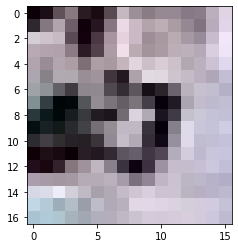

In [33]:
plt.imshow(jersey_crop)

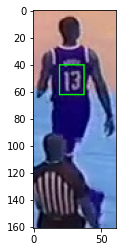

In [32]:
out = mmcv.imshow_bboxes(img, result, show=False)
plt.imshow(out)

In [3]:
mobile = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/ubuntu/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [2]:
from torchvision.models.mobilenet import MobileNetV2
from torchvision.models.resnet import ResNet, Bottleneck

In [3]:
class ResNet50Jersey(ResNet):
    def __init__(self, block, layers):
        super(ResNet50Jersey, self).__init__(block, layers)
        
        self.fc = nn.Linear(512 * block.expansion, 4)
        self._digit1 = nn.Linear(512 * block.expansion, 11)
        self._digit2 = nn.Linear(512 * block.expansion, 11)
        
    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        length_logits = self.fc(x)
        digit1_logits = self._digit1(x)
        digit2_logits = self._digit2(x)

        return length_logits, digit1_logits, digit2_logits

In [4]:
r50 = ResNet50Jersey(Bottleneck, [3, 4, 6, 3])

In [5]:
r50(torch.randn(1,3,224,224))

(tensor([[-0.0145, -0.6461, -0.0444, -0.3736]], grad_fn=<AddmmBackward>),
 tensor([[-0.0643,  0.4664,  1.1812, -0.4559, -0.2835,  0.0154,  0.0290, -0.9409,
           1.0347,  0.4989, -0.2786]], grad_fn=<AddmmBackward>),
 tensor([[-0.2194, -0.3891, -0.6125,  0.0728,  0.6496, -0.2755, -0.0445, -0.0297,
          -0.2700, -1.2631,  0.1732]], grad_fn=<AddmmBackward>))

### TensorRT

In [19]:
import torch
from torch2trt import torch2trt
from torchvision.models.alexnet import alexnet
from torch2trt_dynamic import torch2trt_dynamic

# create example data
x = torch.ones((1, 3, 54, 54)).cuda()

# convert to TensorRT feeding sample data as input
model_trt = torch2trt_dynamic(class_model, [x], fp16_mode=True)

ModuleNotFoundError: No module named 'torch2trt_dynamic'

In [17]:
x_trt = torch.rand((2, 3, 54, 54)).cuda()


st = time.time()
for i in range(1000):
    r = model_trt(x_trt)
#     print(r[0].shape, r[1].shape, r[2].shape)
#     break
print(time.time() - st)

0.17813611030578613


In [18]:
x_orig = torch.rand((2, 3, 54, 54)).cuda()


st = time.time()
for i in range(1000):
    r = class_model(x_orig)
#     print(r[0].shape, r[1].shape, r[2].shape)
#     break
print(time.time() - st)

2.8358495235443115
